# Calculate emissions changes in well-mixed gas levels
Calculate the emissions changes in well-mixed gases at hemisphereic and globally averaged levels. 

In [1]:
import netCDF4 as nc
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time

In [2]:
# Input gas levels
input_folder = "../input/"
output_folder = "../output/GHGs/"
input_co2_mole = "mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"
input_no2_mole = "mole-fraction-of-nitrous-oxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"
input_ch4_mole = "mole-fraction-of-methane-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"

# We need to know the names of relevant variables in each of the different files
gases = {"co2": input_co2_mole, "n2o": input_no2_mole, "ch4": input_ch4_mole}
key_variables = {
    "co2": "mole_fraction_of_{}_in_air".format("carbon_dioxide"),
    "n2o": "mole_fraction_of_{}_in_air".format("nitrous_oxide"), 
    "ch4": "mole_fraction_of_{}_in_air".format("methane")
}
path_var_names = {"co2": "CO2(ppm)", "n2o": "N2O(ppb)", "ch4": "CH4(ppb)"}

# Modification factors
mod_input_folder = "../../COVID19_emissions_data/global_pathways/"
mod_input_baseline = "Base_pathway.xlsx"
mod_input_ff = "FossilFuel_pathway.xlsx"
mod_input_2yr= "TwoYearBlip_pathway.xlsx"
mod_input_mg = "ModerateGreen_pathway.xlsx"
mod_input_sg = "StrongGreen_pathway.xlsx"

pathway_files = [mod_input_ff, mod_input_2yr, mod_input_mg, mod_input_sg]

year_range = np.arange(2020, 2050.01)
t0 = 2019
tcutoff = (2050.99 - 1850) * 365

In [3]:
baseline = pd.read_excel(mod_input_folder + mod_input_baseline, header=0, index_col=1, sheet_name="Concentrations")
baseline

,Unnamed: 0,CO2(ppm),CH4(ppb),N2O(ppb),CF4(ppt),C2F6(ppt),C6F14(ppt),HFC23(ppt),HFC32(ppt),HFC43_10(ppt),...,MCF(ppt),HCFC22(ppt),HCFC141B(ppt),HCFC142B(ppt),HALON1211(ppt),HALON1202(ppt),HALON1301(ppt),HALON2402(ppt),CH3BR(ppt),CH3CL(ppt)
year,,,,,,,,,,,,,,,,,,,,,
1765.041667,0,278.051529,722.000000,273.000000,34.497000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097500,547.996000
1765.125000,1,278.054028,722.305451,273.000596,34.496996,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.580582,533.047268
1765.208333,2,278.056565,722.608130,273.001271,34.496993,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.114799,519.293771
1765.291667,3,278.059133,722.908063,273.002024,34.496989,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,11.695094,506.639942
1765.375000,4,278.061730,723.205274,273.002856,34.496986,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,11.316909,494.997858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050.625000,3427,513.827036,1680.684661,332.274018,103.979962,6.467354,0.468703,27.882544,0.334575,0.218468,...,0.002966,174.758049,17.415766,8.266786,0.771551,5.603635e-09,2.181903,0.044494,7.804962,408.880765
2050.708333,3428,514.078656,1680.389648,332.317316,104.030333,6.471956,0.469114,27.872806,0.331860,0.218008,...,0.002917,173.834760,17.362108,8.235610,0.768321,5.444903e-09,2.179705,0.044311,7.804962,408.880765
2050.791667,3429,514.330293,1680.097266,332.360584,104.080704,6.476557,0.469525,27.863072,0.329189,0.217551,...,0.002869,172.914400,17.308487,8.204523,0.765103,5.290667e-09,2.177506,0.044129,7.804962,408.880765


In [4]:
def calc_means(df, year_range):
    to_return = pd.DataFrame(index=year_range, columns=["mean"])
    for year in year_range:
        to_return["mean"][year] = np.nanmean(df[df["year"].floordiv(1) == year][df.columns[1]])
    return to_return

In [5]:
def make_year_into_days(year):
    return (year - 1850) * 365 # The calendar is defined using the 365 day calendar. 

In [6]:
def closest_ind(info, time):
    return [np.where(
        abs(info - time) == min(abs(info - time))
    )[0][-1]]

In [7]:
monthly_range = [date for date in baseline.index if date >= min(year_range) and date < max(year_range) + 1]

Plot of scenario FossilFuel for co2
End time factor is 1.0168698327550783
Plot of scenario TwoYearBlip for co2
End time factor is 0.9971930396168879
Plot of scenario ModerateGreen for co2
End time factor is 0.8814391257083551
Plot of scenario StrongGreen for co2
End time factor is 0.8441754360544889
Plot of scenario FossilFuel for n2o
End time factor is 1.001664329916826
Plot of scenario TwoYearBlip for n2o
End time factor is 0.9996637325260683
Plot of scenario ModerateGreen for n2o
End time factor is 0.9868602433147332
Plot of scenario StrongGreen for n2o
End time factor is 0.9696603752599477
Plot of scenario FossilFuel for ch4
End time factor is 1.0463058189569725
Plot of scenario TwoYearBlip for ch4
End time factor is 0.9997425778839764
Plot of scenario ModerateGreen for ch4
End time factor is 0.8389089507499804
Plot of scenario StrongGreen for ch4
End time factor is 0.7338570545073296


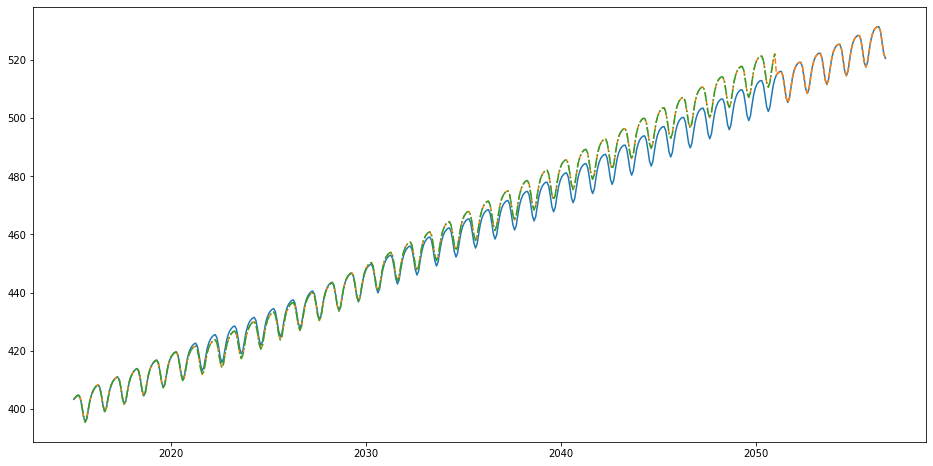

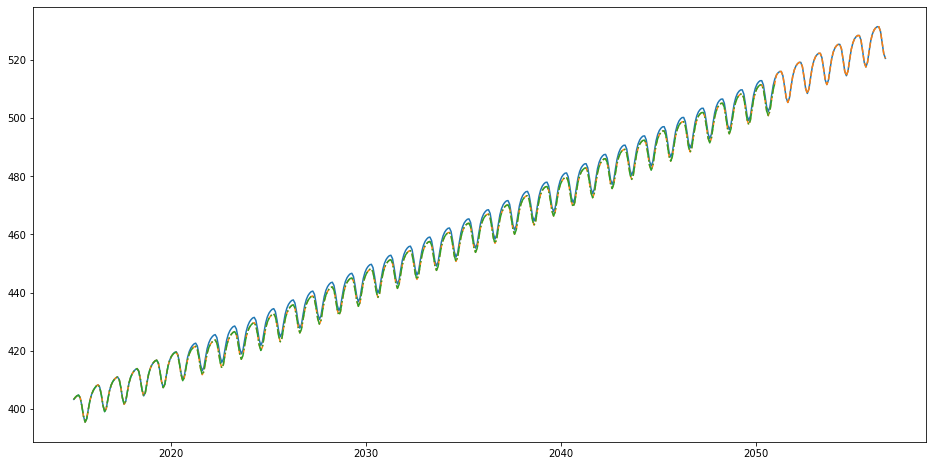

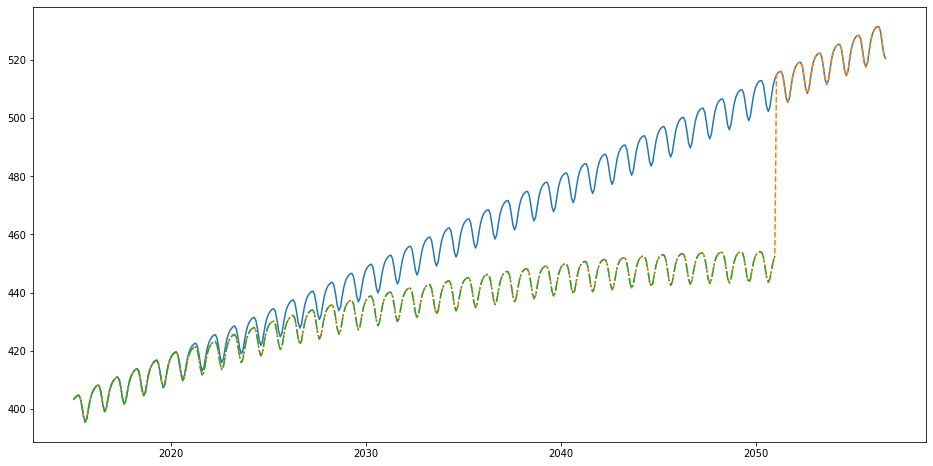

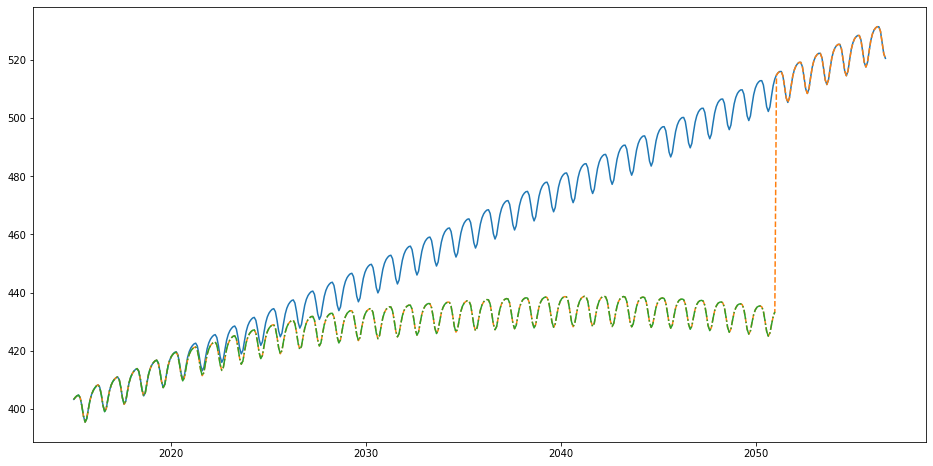

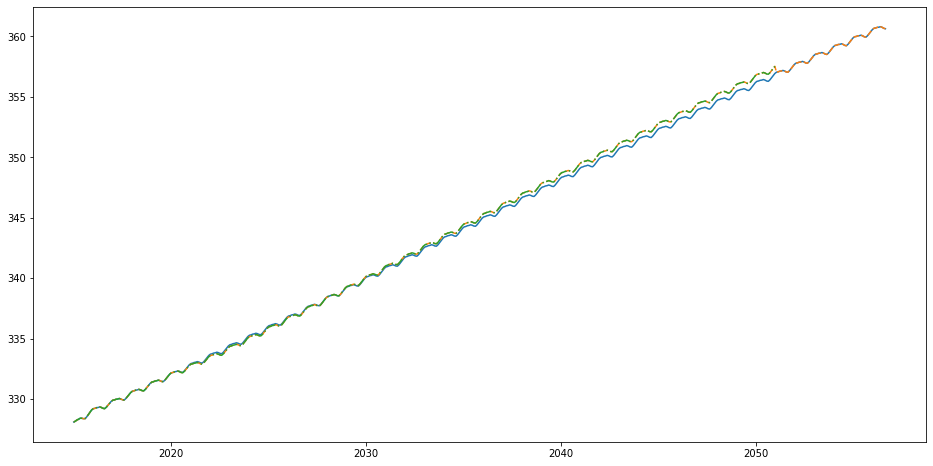

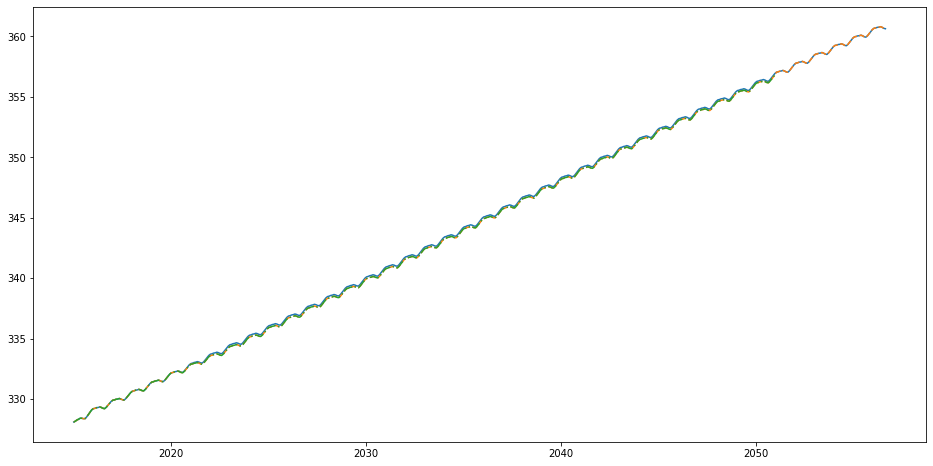

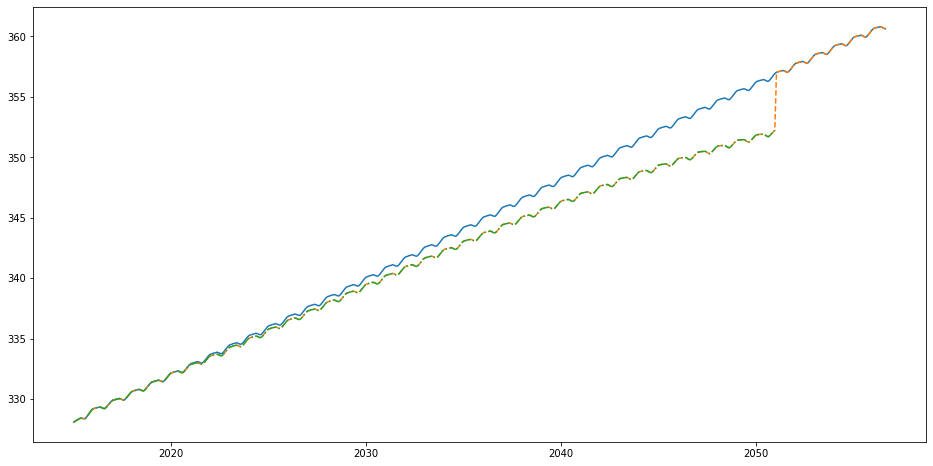

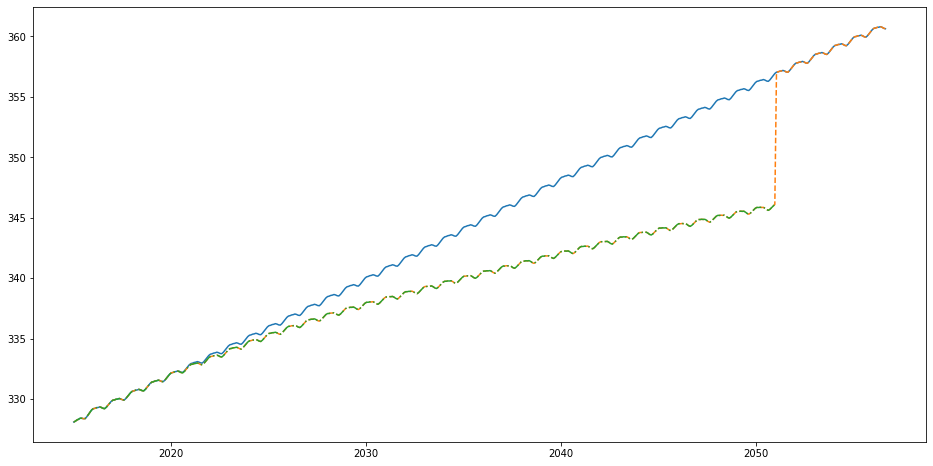

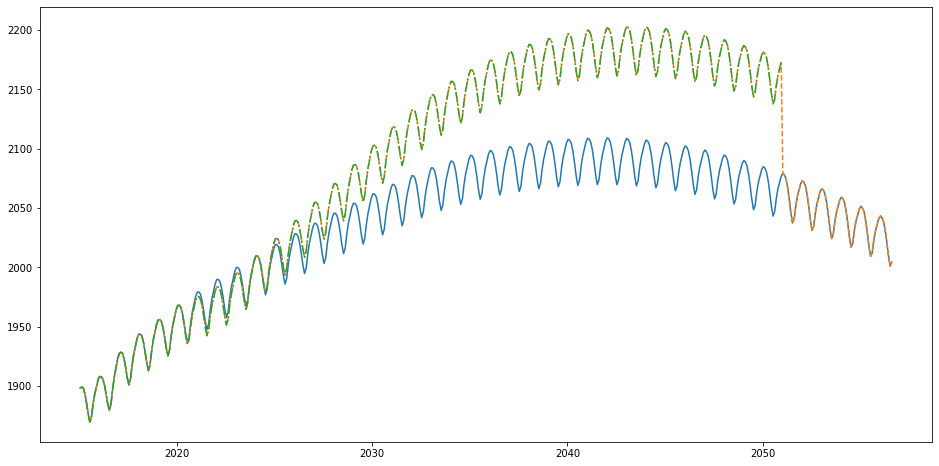

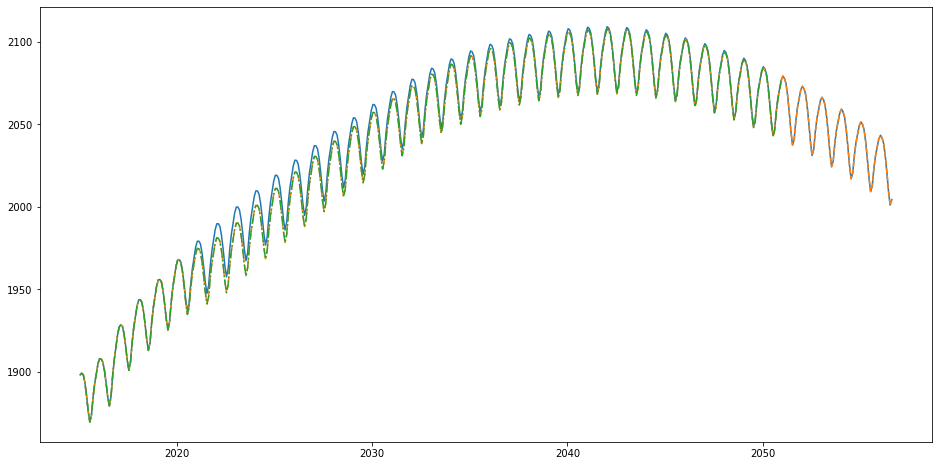

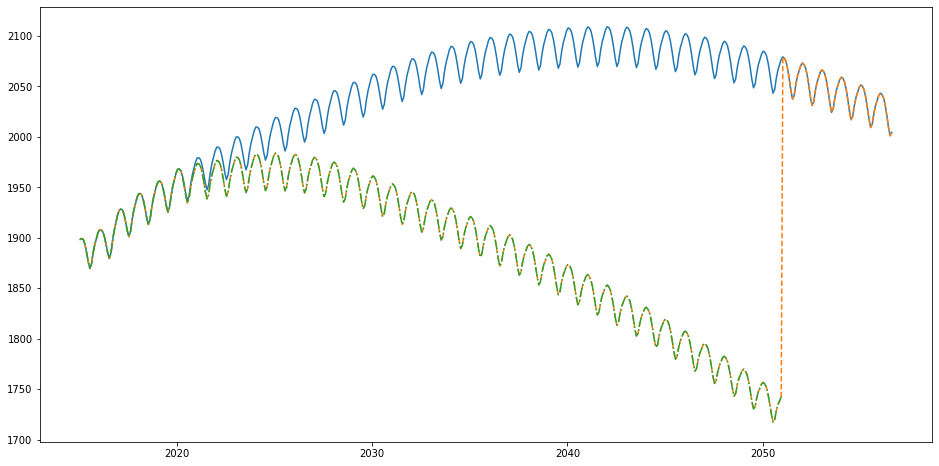

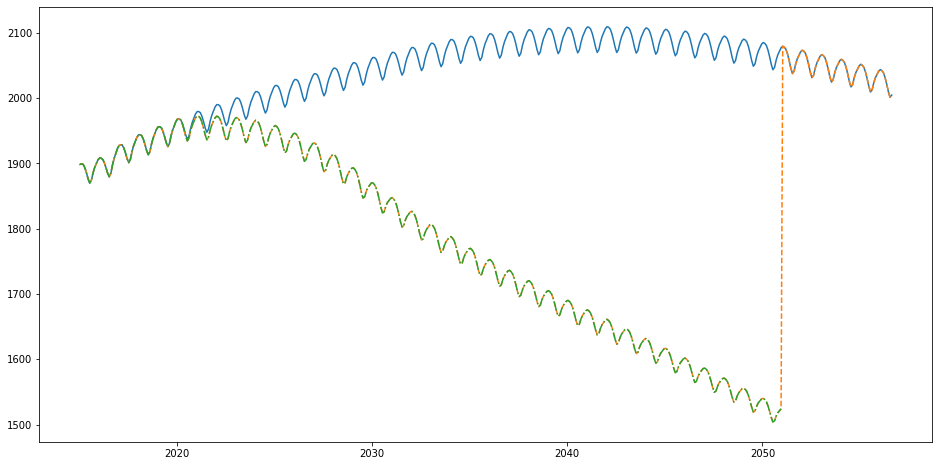

In [8]:
for gas, gas_file in gases.items():
    key_variable = key_variables[gas]
    for fileind in range(len(pathway_files)):
        file = pathway_files[fileind]
        scenario_string = file.split("_")[0]
        data = copy_netcdf_file(gas_file, input_folder, output_folder, scenario_string)
        output = data.variables[key_variable][...]
        path_df = pd.read_excel(mod_input_folder + file, header=0, index_col=1, sheet_name="Concentrations")
        #t0_ind = closest_ind(data.variables["time"][:], make_year_into_days(t0))
        #conc_at_t0 = output[t0_ind, :]
        for time in monthly_range:
            timeind = closest_ind(data.variables["time"][:], make_year_into_days(time))
            time_factor = path_df[path_var_names[gas]].loc[time] / baseline[path_var_names[gas]].loc[time]
            output[timeind, ...] = (output[timeind, :]) * time_factor 
        print("Plot of scenario {} for {}".format(scenario_string, gas))
        print("End time factor is {}".format(time_factor))
        plt.figure(figsize=(16, 8))
        plt.plot(data.variables["time"][:500] / 365 + 1850, data.variables[key_variable][:500, 1])
        plt.plot(data.variables["time"][:500] / 365 + 1850, output[:500, 1], linestyle="--")
        data.variables[key_variable][:, :] = output
        data.close()
        data = cutoff_netcdf_time(
            output_folder, output_folder, gas_file + scenario_string, tcutoff, scenario_string="_to_2050.nc"
        )
        plt.plot(data.variables["time"][:500] / 365 + 1850, data.variables[key_variable][:500, 1], linestyle="-.")
        data.close()
        

# Sandbox

In [9]:
blob

NameError: name 'blob' is not defined

In [ ]:
data.close()

In [ ]:
tcutoff

In [ ]:
data.variables["time"][-1] / 365 + 1850

In [ ]:
plt.plot(data.variables["time"][:])


In [ ]:
data = nc.Dataset(input_folder + gases["co2"])

In [ ]:
plt.plot(data.variables["time"][:410] / 365 + 1850, data.variables["mole_fraction_of_carbon_dioxide_in_air"][:410] * 0.88)

In [ ]:
data = nc.Dataset(output_folder+  gas_file + scenario_string)

In [ ]:
path_df[path_var_names[gas]].loc[time] / baseline[path_var_names[gas]].loc[time]

In [ ]:
data = cutoff_netcdf_time(
            output_folder, output_folder, gas_file + scenario_string, tcutoff, scenario_string="_to_2050.nc"
        )